# Workflow

In [1]:
import numpy as np
import sys

sys.path.append('../hydra_tod/')

# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator

In [2]:
# Load the simulation results
import pickle
from simulation import TODSimulation

with open('tod_simulation_single.pkl', 'rb') as f:
    tod_sim = pickle.load(f)


In [3]:
sky_params = tod_sim.sky_params
nd_rec_params = tod_sim.nd_rec_params
gain_params_setting = tod_sim.gain_params_setting
calibration_indices = tod_sim.calibration_5_indices
alpha = tod_sim.alpha

TOD_setting = tod_sim.TOD_setting
t_list = tod_sim.t_list
gain_proj = tod_sim.gain_proj
Tsky_operator_setting = tod_sim.Tsky_operator_setting
nd_rec_operator = tod_sim.nd_rec_operator

logfc = tod_sim.logfc

# Additional variables needed for the analysis
pixel_indices = tod_sim.pixel_indices
nside = tod_sim.nside
f0 = tod_sim.f0
T_ndiode = tod_sim.T_ndiode
rec_params = tod_sim.rec_params
logf0 = tod_sim.logf0  # Convert to list format as expected later

In [4]:
# init_Tsys_params = np.hstack([sky_params, nd_rec_params])
init_noise_params_list = [[logf0, alpha]]
init_Tloc_params_list = [nd_rec_params]
init_Tsky_params = sky_params


prior_std_frac = 0.1

gain_prior_mean = gain_params_setting
gain_prior_cov_inv = 1.0 / (prior_std_frac * gain_params_setting)**2  # Prior STD ~10%
gain_prior_cov_inv[gain_prior_cov_inv > 100] = 100
# gain_prior_cov_inv[0] = 2.51 # DC mode: Prior STD ~10%

Tsky_prior_cov_inv = 1.0 / (prior_std_frac * sky_params)**2
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = 1.0 / (nd_rec_params)**2  # Prior STD ~100%
aux[0] = 10.0
aux[1] = 1.0

Trec_prior_cov_inv_list = [aux] # Effectively no prior


In [ ]:
# Import the FlickerCorrEmulator class first
from full_Gibbs_sampler import TOD_Gibbs_sampler

Tsys_samples, all_gain_samples, all_noise_samples= \
    TOD_Gibbs_sampler(
        [TOD_setting],
        [t_list],
        [gain_proj],
        [Tsky_operator_setting],
        [nd_rec_operator],
        init_Tsky_params,
        init_Tloc_params_list,
        init_noise_params_list,
        [logfc],
        wnoise_var=2.5e-6,
        Tsky_prior_cov_inv=Tsky_prior_cov_inv,
        Tsky_prior_mean=sky_params,
        local_Tloc_prior_cov_inv_list=Trec_prior_cov_inv_list,
        local_Tloc_prior_mean_list=[nd_rec_params],
        local_gain_prior_cov_inv_list=[gain_prior_cov_inv],
        local_gain_prior_mean_list=[gain_prior_mean],
        # local_noise_prior_func_list=[log_prior_noise],
        joint_Tsys_sampling=True,
        smooth_gain_model="linear",
        noise_sampler_type="emcee",
        noise_Jeffreys_prior=False,
        n_samples=2000,
        tol=1e-20,
        debug=True,)

In [ ]:
np.save("outputs/GS5/Tsys_samples_linearG.npy", Tsys_samples)
np.save("outputs/GS5/gain_samples_linearG.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS5/noise_samples_linearG.npy", np.concatenate(all_noise_samples, axis=0))


In [5]:
param_names_compact = [
    r'$p_{{\rm g},0}$', r'$p_{{\rm g},1}$', r'$p_{{\rm g},2}$', r'$p_{{\rm g},3}$',  # 4 gain parameters
    r'$p_{{\rm loc},0}$', r'$p_{{\rm loc},1}$', r'$p_{{\rm loc},2}$', r'$p_{{\rm loc},3}$', r'$p_{{\rm loc},4}$',  # 5 receiver parameters
    r'$\log_{10} f_0$', r'$\alpha$'  # 2 noise parameters
]

In [6]:
Tsys_samples = np.load("outputs/GS5/Tsys_samples_linearG.npy")
gain_samples = np.load("outputs/GS5/gain_samples_linearG.npy")
noise_samples = np.load("outputs/GS5/noise_samples_linearG.npy")

### a. Trace plots

In [ ]:
from MCMC_diagnostics import diagnostics

In [ ]:
diagnostics(gain_samples, param_names=param_names_compact[:4], max_plots=5)

In [ ]:
diagnostics(noise_samples, param_names=param_names_compact[9:], max_plots=5)

In [7]:
from visualisation import plot_residual_histogram, view_patch_map, gnomview_patch
from analysis import explore_posterior_joint_Tsys

292


All pixels - Mean: 0.0018, Std: 0.1601, RMS: 0.1601
All pixels - 16th-84th percentile: [-0.0614, 0.1103]
Internal pixels - Mean: 0.0039, Std: 0.1477, RMS: 0.1478
Internal pixels - 16th-84th percentile: [-0.0537, 0.0948]
Plot saved to: figures/new/GS5_mean_res.pdf


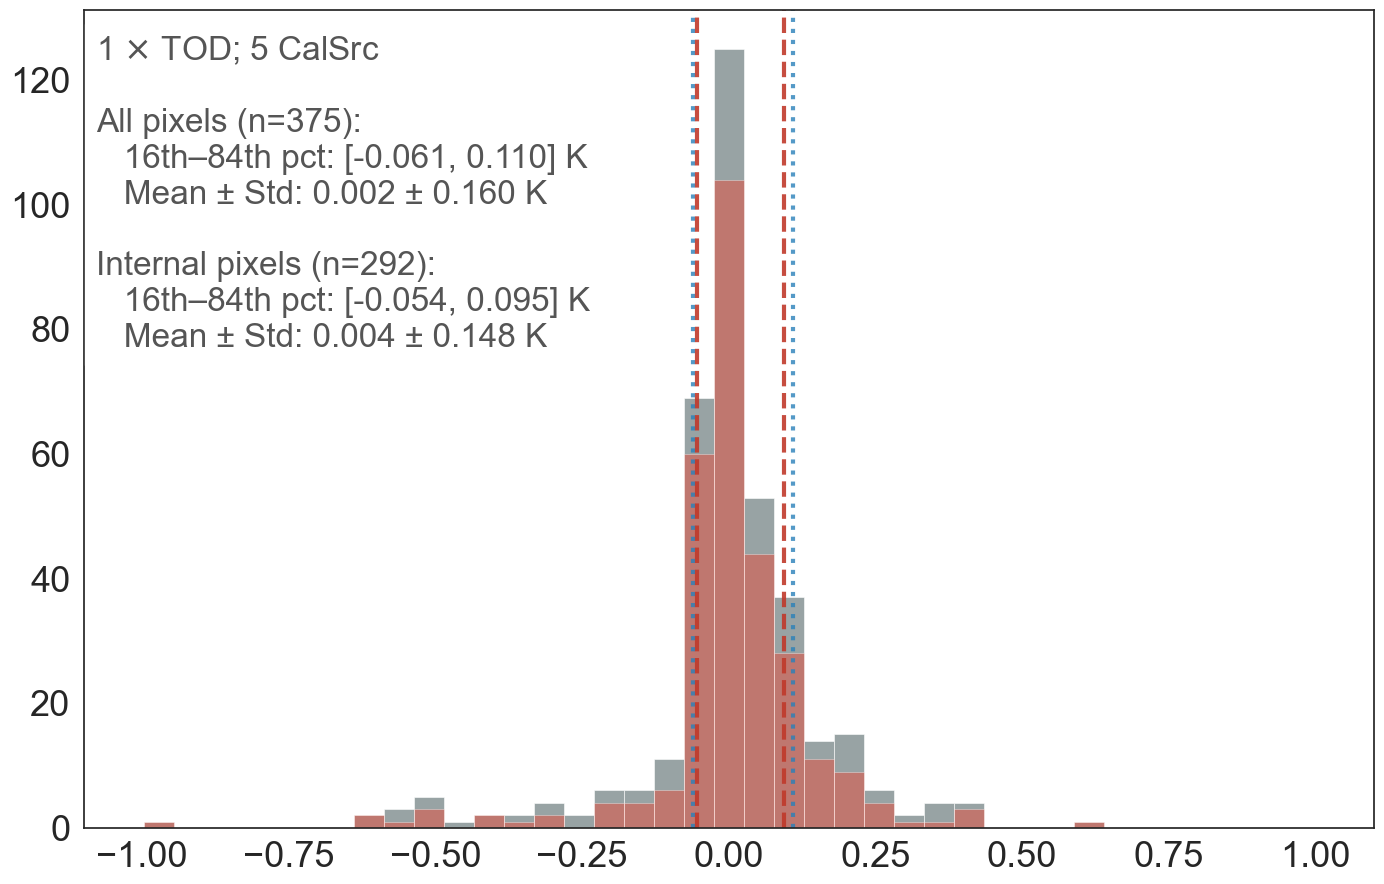

All pixels - Mean: 0.0021, Std: 0.1593, RMS: 0.1593
All pixels - 16th-84th percentile: [-0.0614, 0.1084]
Internal pixels - Mean: 0.0044, Std: 0.1462, RMS: 0.1462
Internal pixels - 16th-84th percentile: [-0.0539, 0.0929]
Plot saved to: figures/new/GS5_median_res.pdf


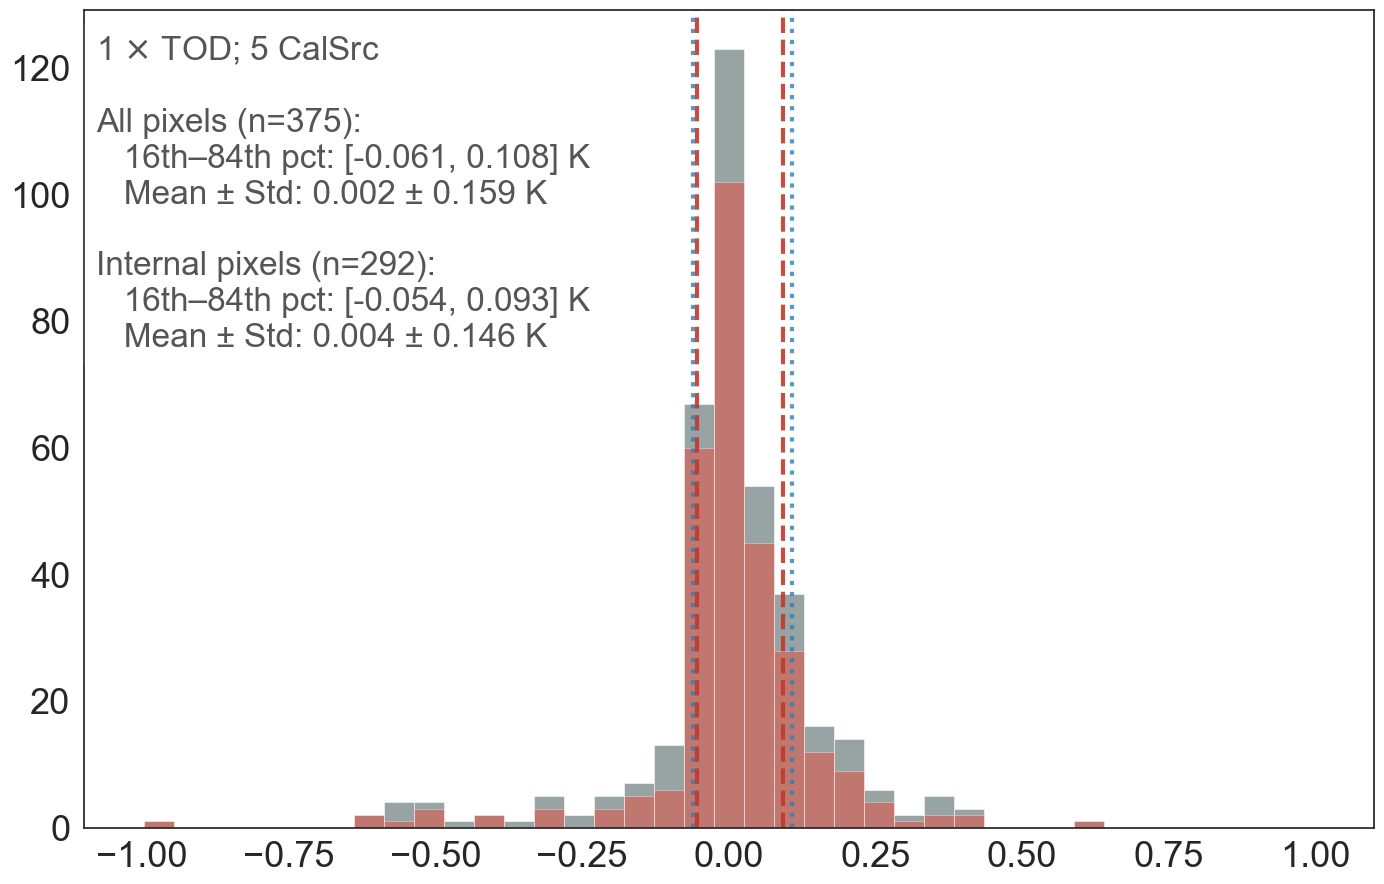

/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be in

{'mean': (array([ 7.92611075,  8.16075908,  7.73888089,  7.5680452 ,  8.47935424,
          7.37430102,  6.87934633,  6.90924086,  6.84416118,  7.04716363,
          6.366988  ,  6.32877387,  5.75935564,  5.81704484,  5.42593725,
          5.19431588,  5.5321621 ,  5.67070214,  5.67532491,  7.93530378,
          8.03499695,  8.26066716,  8.41256399,  8.08384382,  7.59676277,
          6.99295939,  6.26639011,  7.03424575,  6.77877112,  6.4974871 ,
          6.59522258,  5.90148316,  6.04038092,  5.54375323,  5.59746008,
          5.21247522,  5.65819247,  6.09605379,  5.86165366,  8.09459524,
         11.03535714,  8.06857715,  7.88449951,  8.13865885,  7.61677039,
          7.82031863,  7.03583078,  6.84624382,  7.17211566,  7.03489299,
          6.49667507,  6.08965895,  5.93468447,  5.88244753,  6.08701176,
          6.01993723,  5.72477155,  5.81896158,  5.99453745,  8.26447844,
          8.12289007,  8.39277522,  8.08984727,  8.34011171,  8.14778424,
          7.50189368,  7.30218

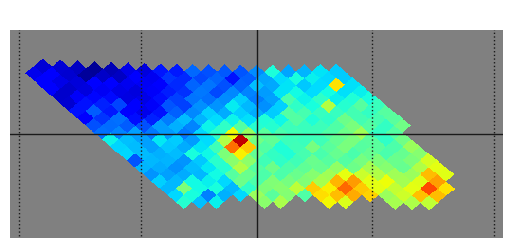

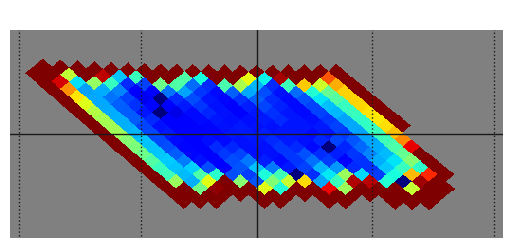

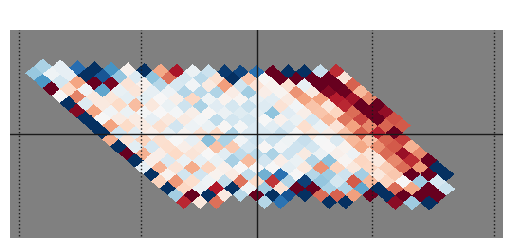

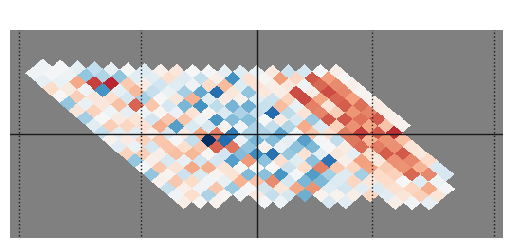

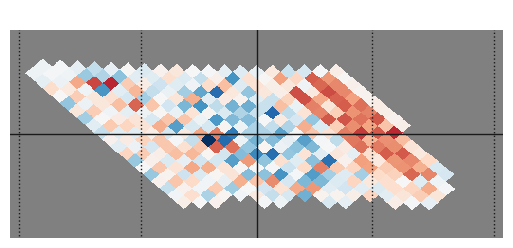

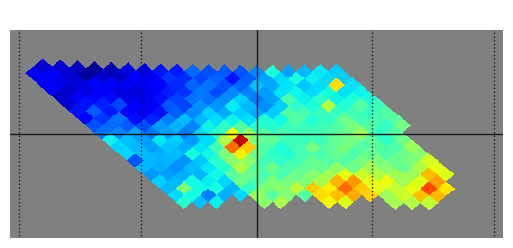

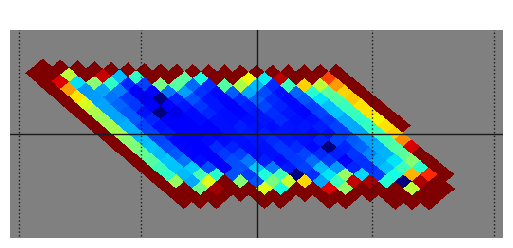

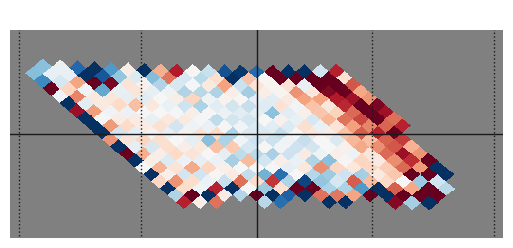

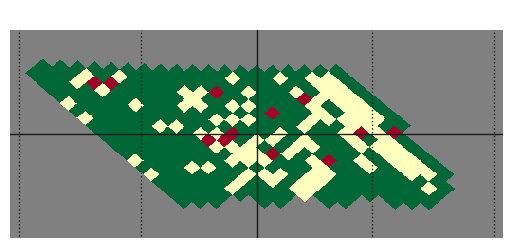

In [8]:
explore_posterior_joint_Tsys(Tsys_samples, 
                             gain_samples, 
                             noise_samples, 
                             sky_params,
                             title_str= r'1 $\times$ TOD; 5 CalSrc',
                             save_path='figures/new/GS5',
                             two_x_TODs=False, 
                             warm_up=0, 
                             cbar=False
                             )
